In [1]:
import numpy as np
np.bool = np.bool_ # bad trick to fix numpy version issue :(
import os
import sys
import shutil
import pickle

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

os.environ["DISPLAY"] = ":0"
os.environ["PYOPENGL_PLATFORM"] = "egl"

In [2]:
# constants
TASK = 'open_drawer'
DATA_FOLDER ='peract_colab/data'
EPISODES_FOLDER = 'colab_dataset/open_drawer/all_variations/episodes'
EPISODE_FOLDER = 'episode%d'
CAMERAS = ['front', 'left_shoulder', 'right_shoulder', 'wrist']
LOW_DIM_SIZE = 4   # {left_finger_joint, right_finger_joint, gripper_open, timestep}
IMAGE_SIZE =  128  # 128x128 - if you want to use higher voxel resolutions like 200^3, you might want to regenerate the dataset with larger images
VARIATION_DESCRIPTIONS_PKL = 'variation_descriptions.pkl' # the pkl file that contains language goals for each demonstration
EPISODE_LENGTH = 10 # max steps for agents
DEMO_AUGMENTATION_EVERY_N = 10 # sample n-th frame in demo
ROTATION_RESOLUTION = 5 # degree increments per axis

# settings
VOXEL_SIZES = [100] # 100x100x100 voxels
NUM_LATENTS = 512 # PerceiverIO latents
SCENE_BOUNDS = [-0.3, -0.5, 0.6, 0.7, 0.5, 1.6] # [x_min, y_min, z_min, x_max, y_max, z_max] - the metric volume to be voxelized
BATCH_SIZE = 1
NUM_DEMOS = 8 # total number of training demonstrations to use while training PerAct
NUM_TEST = 2 # episodes to evaluate on

In [3]:
sys.path.append('peract_colab')
data_path = os.path.join(DATA_FOLDER, EPISODES_FOLDER)

train_replay_storage_dir = 'replay_train'
if not os.path.exists(train_replay_storage_dir):
  os.mkdir(train_replay_storage_dir)

test_replay_storage_dir = 'replay_test'
if not os.path.exists(test_replay_storage_dir):
  os.mkdir(test_replay_storage_dir)

## Data Loading & Preprocessing

Demo 1 | 108 total steps



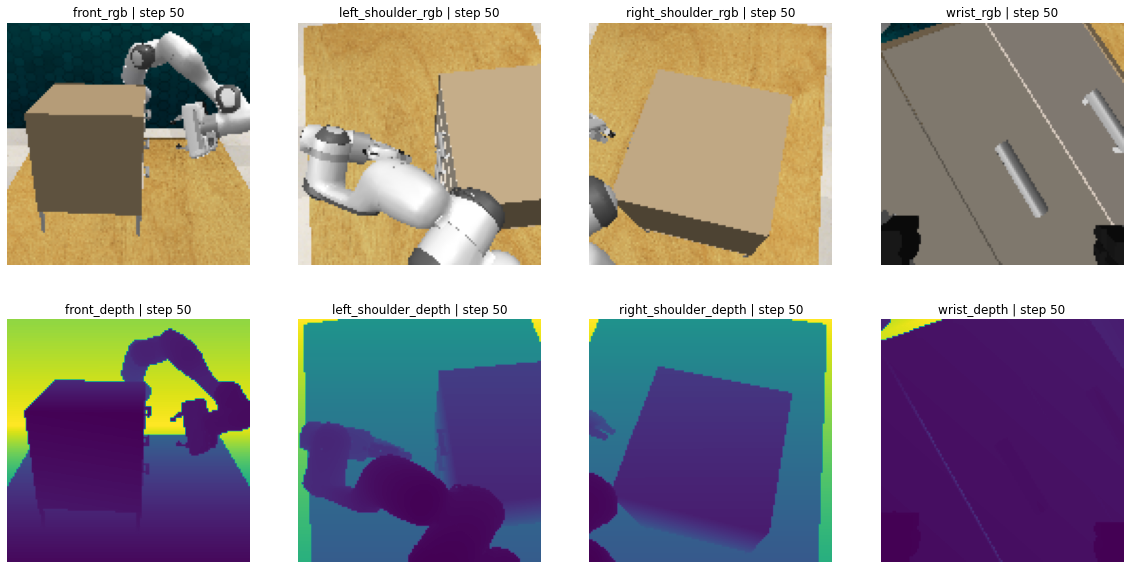

In [4]:
from rlbench.utils import get_stored_demo
from rlbench.backend.utils import extract_obs

# what to visualize
episode_idx_to_visualize = 1 # out of 10 demos
ts = 50 # timestep out of total timesteps

# get demo
demo = get_stored_demo(data_path=data_path,
                      index=episode_idx_to_visualize)

# extract obs at timestep
obs_dict = extract_obs(demo._observations[ts], CAMERAS, t=ts)

# total timesteps in demo
print(f"Demo {episode_idx_to_visualize} | {len(demo._observations)} total steps\n")

# plot rgb and depth at timestep
fig = plt.figure(figsize=(20, 10))
rows, cols = 2, len(CAMERAS)

plot_idx = 1
for camera in CAMERAS:
  # rgb
  rgb_name = "%s_%s" % (camera, 'rgb')
  rgb = np.transpose(obs_dict[rgb_name], (1, 2, 0))
  fig.add_subplot(rows, cols, plot_idx)
  plt.imshow(rgb)
  plt.axis('off')
  plt.title("%s_rgb | step %s" % (camera, ts))

  # depth
  depth_name = "%s_%s" % (camera, 'depth')
  depth = np.transpose(obs_dict[depth_name], (1, 2, 0)).reshape(IMAGE_SIZE, IMAGE_SIZE)
  fig.add_subplot(rows, cols, plot_idx+len(CAMERAS))
  plt.imshow(depth)
  plt.axis('off')
  plt.title("%s_depth | step %s" % (camera, ts))

  plot_idx += 1

plt.show()

### Create Replay Buffer

In [ ]:
# Adapted from: https://github.com/stepjam/ARM/blob/main/arm/c2farm/launch_utils.py

from yarr.utils.observation_type import ObservationElement
from yarr.replay_buffer import ReplayElement, ReplayBuffer
from yarr.replay_buffer.uniform_replay_buffer import UniformReplayBuffer


def create_replay(batch_size: int,
                  timesteps: int,
                  save_dir: str,
                  cameras: list,
                  voxel_sizes,
                  replay_size=3e5):

    trans_indicies_size = 3 * len(voxel_sizes)
    rot_and_grip_indicies_size = (3 + 1)
    gripper_pose_size = 7
    ignore_collisions_size = 1
    max_token_seq_len = 77
    lang_feat_dim = 1024
    lang_emb_dim = 512

    # low_dim_state
    observation_elements = []
    observation_elements.append(
        ObservationElement('low_dim_state', (LOW_DIM_SIZE,), np.float32))

    # rgb, depth, point cloud, intrinsics, extrinsics
    for cname in cameras:
        observation_elements.append(
            ObservationElement('%s_rgb' % cname, (3, IMAGE_SIZE, IMAGE_SIZE,), np.float32))
        observation_elements.append(
            ObservationElement('%s_depth' % cname, (1, IMAGE_SIZE, IMAGE_SIZE,), np.float32))
        observation_elements.append(
            ObservationElement('%s_point_cloud' % cname, (3, IMAGE_SIZE, IMAGE_SIZE,), np.float32)) # see pyrep/objects/vision_sensor.py on how pointclouds are extracted from depth frames
        observation_elements.append(
            ObservationElement('%s_camera_extrinsics' % cname, (4, 4,), np.float32))
        observation_elements.append(
            ObservationElement('%s_camera_intrinsics' % cname, (3, 3,), np.float32))

    # discretized translation, discretized rotation, discrete ignore collision, 6-DoF gripper pose, and pre-trained language embeddings
    observation_elements.extend([
        ReplayElement('trans_action_indicies', (trans_indicies_size,),
                      np.int32),
        ReplayElement('rot_grip_action_indicies', (rot_and_grip_indicies_size,),
                      np.int32),
        ReplayElement('ignore_collisions', (ignore_collisions_size,),
                      np.int32),
        ReplayElement('gripper_pose', (gripper_pose_size,),
                      np.float32),
        ReplayElement('lang_goal_embs', (max_token_seq_len, lang_emb_dim,), # extracted from CLIP's language encoder
                      np.float32),
        ReplayElement('lang_goal', (1,), object), # language goal string for debugging and visualization
    ])

    extra_replay_elements = [
        ReplayElement('demo', (), np.bool),
    ]

    replay_buffer = UniformReplayBuffer( # all tuples in the buffer have equal sample weighting
        save_dir=save_dir,
        batch_size=batch_size,
        timesteps=timesteps,
        replay_capacity=int(replay_size),
        action_shape=(8,), # 3 translation + 4 rotation quaternion + 1 gripper open
        action_dtype=np.float32,
        reward_shape=(),
        reward_dtype=np.float32,
        update_horizon=1,
        observation_elements=observation_elements,
        extra_replay_elements=extra_replay_elements
    )
    return replay_buffer

train_replay_buffer = create_replay(batch_size=BATCH_SIZE,
                                    timesteps=1,
                                    save_dir=train_replay_storage_dir,
                                    cameras=CAMERAS,
                                    voxel_sizes=VOXEL_SIZES)

test_replay_buffer = create_replay(batch_size=BATCH_SIZE,
                                   timesteps=1,
                                   save_dir=test_replay_storage_dir,
                                   cameras=CAMERAS,
                                   voxel_sizes=VOXEL_SIZES)
